In [ ]:
# Setting up the environment
!git clone https://github.com/Rualito/KAT-RSP-Workshop2023
!pip install git+https://gitlab.tue.nl/20235021/rsp
!pip install rsp[utils]

import rsp # If this works, then the environment is well configured
import rsp.utils

# From pulses to gates

The experimental parameters are loaded up first from a json configuration file. It defines the atomic energy levels which are to be considered for computation, the various trap and laser parameters, as well as some additional settings such as environment temperature.

Here we also define the initial configuration for the atomic system, giving it a standard lattice unit and attributing labels to the different atoms

In [1]:
import numpy as np

from rsp.core.experiment import AtomSystem, ExperimentSetup

# Loading experimental settings
# exp = ExperimentSetup.fromFile('/content/KAT-RSP-Workshop2023/code/hardware_config.json') 

exp = ExperimentSetup.fromFile('hardware_config.json')

# Initializing the atom system
lattice_unit = 3e-6

atomsys = AtomSystem()
atom = exp.get_atom()

# loading the atom system with atoms and respective positions
atomsys.add_atom('A', atom, np.array([0,0,0]))


## Rabi oscillations
The fundamental interaction between atoms and lasers yields Rabi Oscillations, which are simply oscillations between two different energy levels.

In [2]:
from rsp.core.circuit.pulses import PulsedGate
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform

# returns a constant amplitude/detuning pulse 
def const_amplitude(transition, amplitude, detuning=0):
    rabi_freq = exp.rabi_freq[{'01':('0','1'), '1r':('1','r')}[transition]]
    duration = int(1/rabi_freq * 1e9)
    amp_wf = ConstantWaveform(duration, amplitude)
    det_wf = ConstantWaveform(duration, -detuning)
    
    return Pulse(amplitude=amp_wf, detuning=det_wf, phase=0)

# To define a pulse one has to attribute transition channels
# which describe which transition does the channel target
pulseX = PulsedGate()
pulseX.new_channel('clock', ('0', '1'))
# pulses can be added to the sequence using the pulse shape,
# the transition channel and the target of the pulse 
pulseX.add_pulse(pulse=const_amplitude('01', 6*np.pi), 
                 channel='clock', target=0)
pulseX._compile_pulses(1e-9)

A pulse is simulated after being included into a quantum circuit, and later ran with `Simulator.run_circuit`.

In [3]:
from rsp.core.circuit import QuantumCircuit
from rsp.core.simulation import Simulator

qc = QuantumCircuit()
# Append an operation to the circuit sequence, setting a target
qc.add_operation(pulseX, ['A']) 

# The simulator requires the experimental configuration and the starting atom lattice
sim = Simulator(exp, atomsys)

# The save_states flag is used to keep track of the states through the evolution
sim.run_circuit(qc, save_states=True)

/home/raul/.local/share/virtualenvs/KAT-RSP-Workshop2023-mWDpBnbD/lib/python3.11/site-packages/rsp/core/simulation/simulator.py:745: UserWarning: Running full evolution, cache checks failed
  warnings.warn("Running full evolution,"


{}

After simulating, we can visualize the rabi oscillations from the state $|0\rangle$ to $|1\rangle$ 

$6\pi$ corresponds to 3 full rotations

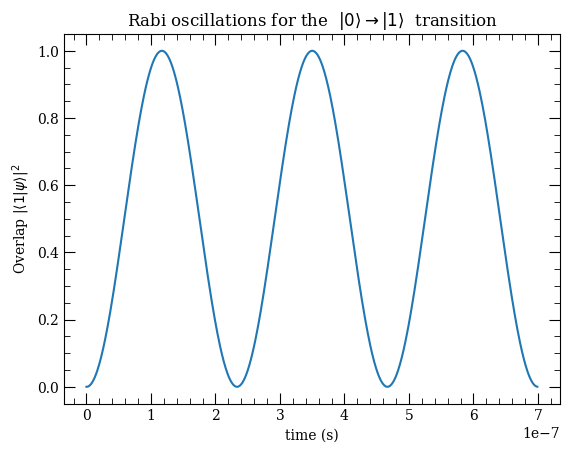

In [4]:
from qutip import ket
import matplotlib.pyplot as plt

overlap = []
for psi in sim.saved_states:
    overlap.append( np.abs((ket('1', 3).dag() * psi).tr())**2)

plt.plot(sim.saved_states_times, overlap)
plt.ylabel(r'Overlap $ |\langle 1|\psi\rangle|^2 $')
plt.xlabel('time (s)')
plt.title(r"Rabi oscillations for the  $|0\rangle\rightarrow|1\rangle$  transition")
plt.show()


It is also interesting to see the state evolution through the Bloch sphere!

The pulse can be interpreted as a rotation along the $x$ axis 

In [ ]:
import qutip 
from qutip import ket, Bloch, basis, qeye

# this projector is needed to convert the qutrit state into a qubit
two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()


# Visualization
from ipywidgets import interactive, IntSlider
def interactive_bloch_sphere(states, times, tail):
    def slider_bloch(ti):
        b = qutip.Bloch()
        b.sphere_color = '#FFFFDD'
        temp_states = states[ ti-tail if ti>tail else 0 : ti+1 ]
        b.point_color = ['b']*len(temp_states)
        b.point_marker = ['o']*len(temp_states)
        b.point_alpha = [*np.linspace(0.1, 1, len(temp_states))]
        b.point_size = [*np.linspace(10, 100, len(temp_states))]
        b.clear()
        for psi in temp_states:
            b.add_states(two_projector*psi, kind='point')
        b.show()
    interactive_plot = interactive(slider_bloch, ti=IntSlider(min=0, max=len(states), description='state index'))
    output = interactive_plot.children[-1]

    return interactive_plot

interactive_bloch_sphere(sim.saved_states, sim.saved_states_times, 20)


Another operation possible with laser pulses are rotations around the $z$ axis

Lets do a z rotation and try to get the state $|+\rangle=\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$, which corresponds to the state on the positive $x$ direction 

In [18]:
qc.reset()

pulseX = PulsedGate()
pulseX.new_channel('clock', ('0', '1'))

# This time we only rotate pi/2 around the sphere
pulseX.add_pulse(pulse=const_amplitude('01', 1/2*np.pi), 
                 channel='clock', target=0)

pulseX._compile_pulses(1e-9)

pulseZ = PulsedGate()
pulseZ.new_channel('clock', ('0', '1'))
# Here we have a detuning which rotates the state around the z axis by pi/2
pulseZ.add_pulse(pulse=const_amplitude('01', 0, 1/2*np.pi), 
                 channel='clock', target=0)
pulseZ._compile_pulses(1e-9)

qc.add_operation(pulseX, ['A']) # rotate around x
qc.add_operation(pulseZ, ['A']) # rotate around z

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

/home/raul/.local/share/virtualenvs/KAT-RSP-Workshop2023-mWDpBnbD/lib/python3.11/site-packages/rsp/core/simulation/simulator.py:745: UserWarning: Running full evolution, cache checks failed
  warnings.warn("Running full evolution,"


{}

Plotting the evolution of the overlap of the state gives us insight into what is happening.

Here we first overlap with $|1\rangle$, and then with $|+\rangle$

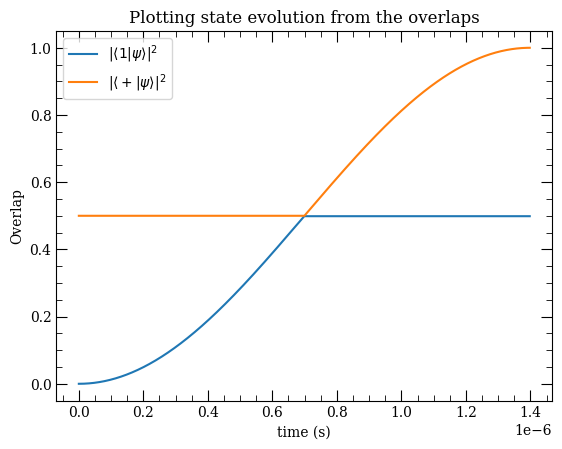

In [19]:
from qutip import ket, Bloch, basis, qeye
import matplotlib.pyplot as plt

overlapX = []
overlapP = []
ket_plus = (ket('0', 3)+ket('1', 3))/np.sqrt(2) # |+> = (|0> + |1>)/sqrt2

for psi in sim.saved_states:
    overlapX.append( np.abs((ket('1', 3).dag() * psi).tr())**2 )
    overlapP.append( np.abs((ket_plus.dag() * psi).tr())**2 )

plt.plot(sim.saved_states_times, overlapX, label=r'$|\langle 1|\psi\rangle|^2$')
plt.plot(sim.saved_states_times, overlapP, label=r'$|\langle +|\psi\rangle|^2$')

plt.ylabel(r'Overlap')
plt.xlabel('time (s)')
plt.title(r"Plotting state evolution from the overlaps")
plt.legend()
plt.show()

We can also see this nicely on the Bloch sphere

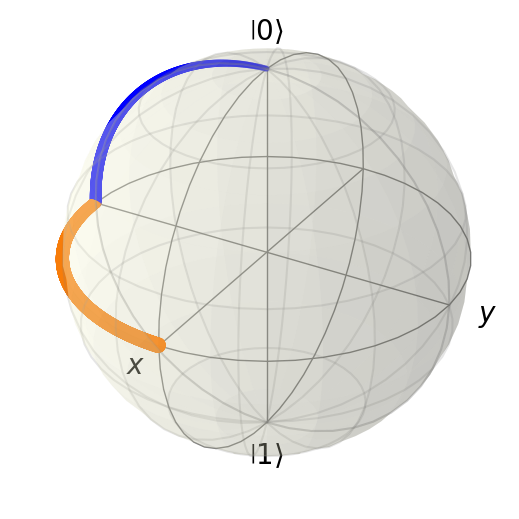

In [26]:
import qutip 
from qutip import ket, Bloch, basis, qeye

# this projector is needed to convert the qutrit state into a qubit
two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()
b = qutip.Bloch()

b.point_color = ['b']*int(len(sim.saved_states)/2) + ['#f77c09']*(len(sim.saved_states)-int(len(sim.saved_states)/2))
b.point_marker = ['o']*len(sim.saved_states)
b.point_alpha = [*np.linspace(0.1, 1, len(sim.saved_states))]
b.point_size = [*np.linspace(10, 100, len(sim.saved_states))]

b.sphere_color = '#FFFFDD'

for psi in sim.saved_states:
    b.add_states(two_projector*psi, kind='point',)
b.show()

A rotation around $x$ with angle $\theta$ can be represented as a matrix exponential 

$$R_x(\theta) = \exp \{ -i \theta X \} $$

with $$X=\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$$

Similarly, a rotation around $z$

$$R_z(\theta) = \exp \{ -i \theta Z \} $$

with $$Z=\begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$$


## Building gates for quantum computation

Lets build some quantum gates. Namely
- $X_{01}$ - $|0\rangle \leftrightarrow |1\rangle$ transition
- $\sqrt{X}$ - half of $X_{01}$
- $Z$ - induces a phase difference of $\pi$ between $|0\rangle \leftrightarrow |1\rangle$
- $S$ - half of Z
- $T$ - half of S
- $X_{1r}$ - $|1\rangle \leftrightarrow |r\rangle$ transition

Can you figure out how they are defined with pulses?

In [ ]:

gateX01 = PulsedGate()
gateX01.new_channel('clock', ('0', '1'))
# Start of gate X01
gateX01.add_pulse(pulse=const_amplitude('01', amplitude=np.pi, detuning=0), 
                  channel='clock', target=0) 
# end of gate X01

gateSX = PulsedGate() # sqrt of X
gateSX.new_channel('clock', ('0', '1'))
# Start of gate SX

# end of gate SX


gateZ = PulsedGate()
gateZ.new_channel('clock', ('0', '1'))
# Start of gate Z01

# end of gate Z01


gateS = PulsedGate() # sqrt of Z
gateS.new_channel('clock', ('0', '1'))
# Start of gate S
gateS.add_pulse(pulse=const_amplitude('01', amplitude=0, detuning=1/2*np.pi), 
                channel='clock', target=0)
# end of gate S


gateT = PulsedGate() # sqrt of S
gateT.new_channel('clock', ('0', '1'))
# Start of gate S

# end of gate S


gateX1r = PulsedGate()
gateX1r.new_channel('ryd', ('1', 'r'))
# Start of gate X1r

# end of gate X1r

The gates can be added to the quantum circuit dictionary so that you may refer to them with their name

In [ ]:
qc = QuantumCircuit()
qc.add_to_dictionary(gateX01, 'X01')
qc.add_to_dictionary(gateSX, 'SX')
qc.add_to_dictionary(gateZ, 'Z')
qc.add_to_dictionary(gateS, 'S')
qc.add_to_dictionary(gateT, 'T')
qc.add_to_dictionary(gateX1r, 'X1r')

Lets use these operations

In [ ]:
qc.reset()

# This sequence of operations will be seen later as a gate
qc.add_operation('S', ['A'])
qc.add_operation('SX', ['A'])
qc.add_operation('S', ['A'])


qc.add_operation('T', ['A'])
qc.add_operation('SX', ['A'])
qc.add_operation('Z', ['A'])
qc.add_operation('X1r', ['A'])


ket_plus = (ket('0', 3) + ket('1', 3))/np.sqrt(2)
ket_minus = (ket('0', 3) - ket('1', 3))/np.sqrt(2)

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)


It is interesting to see what this sequence of operations does on the Bloch sphere

In [ ]:
import qutip 
from qutip import ket

two_projector = ket('0', 2) * ket('0', 3).dag() +  ket('1', 2) * ket('1', 3).dag()
b = qutip.Bloch()

b.point_color = ['b']*len(sim.saved_states)
b.point_marker = ['o']*len(sim.saved_states)
b.point_alpha = [*np.linspace(0.1, 1, len(sim.saved_states))]
b.point_size = [*np.linspace(10, 100, len(sim.saved_states))]

b.sphere_color = '#FFFFDD'

for psi in sim.saved_states:
    b.add_states(two_projector*psi, kind='point',)
b.show()

### Multiple atom operations

So far we have looked into single qubit rotations on a single atom. 

Things become more fun with more atoms! 

Lets add one more and see which operations we can do

In [ ]:
atomsys = AtomSystem()

atom = exp.get_atom()
lattice_unit = 3e-6 # default distance between atoms is 3 \mu m

positions = {'A': lattice_unit * np.array([0,0,0]),
             'B': lattice_unit * np.array([1,0,0])}

# loading the atom system with atoms and respective positions
for label, pos in positions.items():
    atomsys.add_atom(label, atom, pos)

qc = QuantumCircuit()

qc.add_to_dictionary(gateX01, 'X')
qc.add_to_dictionary(gateX1r, 'X1r')



Introducing the Hadamard gate to the gate dictionary

In [ ]:
# New gate for the circuit: Hadamard
gateH = PulsedGate()
gateH.new_channel('clock', ('0', '1'))

# S gate
gateH.add_pulse(pulse=const_amplitude('01', 0, 1/2*np.pi), 
                channel='clock', target=0)
gateH.shift_pulses(-gateH.max_time) # shifting pulses back to avoid overlap of pulses

# SX gate
gateH.add_pulse(pulse=const_amplitude('01', 1/2*np.pi), 
                channel='clock', target=0) 
gateH.shift_pulses(-gateH.max_time)

# S gate
gateH.add_pulse(pulse=const_amplitude('01', 0, 1/2*np.pi), 
                channel='clock', target=0)
gateH.shift_pulses(-gateH.max_time)

qc.add_to_dictionary(gateH, 'H')

from rsp.utils.visualize import plot_pulsed_gate
import matplotlib.pyplot as plt

plot_pulsed_gate(gateH)
plt.legend()
plt.show()

<img src="ryd pulse.png" width="400"/>  

We will call this pulse sequence `Ryd`

In [ ]:

gateRy = PulsedGate()
gateRy.new_channel('clock', ('0', '1'))
gateRy.new_channel('ryd', ('1', 'r'))

gateRy.add_pulse(const_amplitude('1r', np.pi), 
                 'ryd', target=0)
gateRy.shift_pulses(-gateRy.max_time)

gateRy.add_pulse(const_amplitude('1r', 2*np.pi), 
                 'ryd', target=1)
gateRy.shift_pulses(-gateRy.max_time)

gateRy.add_pulse(const_amplitude('1r', np.pi), 
                 'ryd', target=0)
gateRy.shift_pulses(-gateRy.max_time)

qc.add_to_dictionary(gateRy, 'Ry')


In [ ]:

gateRy = PulsedGate()
gateRy.new_channel('clock', ('0', '1'))
gateRy.new_channel('ryd', ('1', 'r'))

gateRy.add_pulse(const_amplitude('1r', np.pi), 
                 'ryd', target=0)
gateRy.shift_pulses(-gateRy.max_time)

gateRy.add_pulse(const_amplitude('1r', 2*np.pi), 
                 'ryd', target=1)
gateRy.shift_pulses(-gateRy.max_time)

gateRy.add_pulse(const_amplitude('1r', np.pi), 
                 'ryd', target=0)
gateRy.shift_pulses(-gateRy.max_time)

qc.add_to_dictionary(gateRy, 'Ry')


To validate our understanding about the gate, we can see what happens to the sign of the different states on superposition

In [ ]:
qc.reset()

qc.add_operation('H', ['A']) # 0 -> +
qc.add_operation('H', ['B']) # 0 -> +

qc.add_operation('Ry', ['A', 'B'])

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

from rsp.utils.state_view import show_state, print_state

print_state(sim.psi)

$|++\rangle = \frac{1}{2} (|00\rangle + |01\rangle +|10\rangle+|11\rangle) \xrightarrow{Ry} \frac{1}{2} (|00\rangle - |01\rangle - |10\rangle - |11\rangle)$

This is similar to the CZ gate, which does the following

$ CZ |++\rangle =  \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle - |11\rangle) $

How can we get the CZ gate with Ry? Some single qubit gates have to be added, can you guess which? 

Note: Global phases can be ignored


In [ ]:
qc.reset()

qc.add_operation('H', ['A']) # 0 -> +
qc.add_operation('H', ['B']) # 0 -> +

# Single qubit gates before


qc.add_operation('Ry', ['A', 'B'])
# Single qubit gates after


# end of single qubit gates

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

from rsp.utils.state_view import show_state, print_state

print(f"|psi>={print_state(sim.psi)}")

The CNOT gate is widely used in quantum circuits to entangle qubits. 

It works as follows: 
 - If the control qubit is $|0\rangle$, then nothing happens to the target qubit. 
 - If the control qubit is $|1\rangle$, then the target qubit is fliped with an $X$ gate. 

For instance

* $CNOT |0\rangle_c |0\rangle_t = |0\rangle_c |0\rangle_t$

* $CNOT |1\rangle_c |0\rangle_t = |1\rangle_c |1\rangle_t$

Thus:
*  $CNOT |+\rangle_c |0\rangle_t = \frac{1}{\sqrt{2}} ( |00\rangle_{ct} + |11\rangle_{ct})$

where $|+\rangle=\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$

The CZ gate can be easily converted into the CNOT gate with single qubit gates

In the `GateDictionary` object all of these gates have already been defined. 

We can use it to load a premade CZ gate

With `interactive_state_plot` we can see the evolution of the state over the sequence through an histogram 

In [ ]:
from rsp.core.circuit.gatedictionary import GateDictionary

gd = GateDictionary(exp)
qc = QuantumCircuit()
qc.add_to_dictionary(gd.CZ(), 'CZ')
qc.add_to_dictionary(gd.H('01'), 'H')

qc.reset()

qc.add_operation('H', ['A']) # 0 -> +

# CNOT sequence
# 1. Hadamard on the target
# 2. CZ between control and target (symmetric gate)
# 3. Hadamard again on target
qc.add_operation('H', ['B'])
qc.add_operation('CZ', ['A', 'B'])
qc.add_operation('H', ['B'])

sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

from rsp.utils.state_view import show_state, print_state, show_state_evol, interactive_state_plot

show_state_evol(sim.saved_states_times, sim.saved_states, ['00', '01', '10', '11'], atomsys)
plt.show()

interactive_state_plot(sim.saved_states, sim.saved_states_times)

This is all for the pulse building section. In the next section there is a demo introducing other capabilities of the simulation platform

# Demo: Quantum State Teleportation 

We will use atom transport to move atom B away after the entanglement operation. The `AtomTransport` operation also allows you to define the transport method. The default method is called `direct`, which simply moves the atoms with a constant speed of $0.5\,\mu m/\mu s$

Here we define the atomic system. After entangling atom $A$ with $B$, we move $B$ far away.


In [28]:
import numpy as np
from rsp.core.experiment import ExperimentSetup, AtomSystem
from rsp.core.circuit.quantumcircuit import QuantumCircuit
from rsp.core.circuit.pulses import PulsedGate
from rsp.core.circuit.gatedictionary import GateDictionary
from rsp.core.circuit import AtomTransport
from rsp.core.simulation import Simulator


exp = ExperimentSetup.fromFile('/content/KAT-RSP-Workshop2023/code/hardware_config.json') # on colab

gd = GateDictionary(exp)

# Loading a gate dictionary into the quantum circuit
qc = QuantumCircuit()
gd.load_cached_qc(qc, ['X','Xr', 'H', 'Z', 'CX', 'CZ'], 
                  exp, None, lattice_unit)
from rsp.core.circuit import Measurement
qc.add_to_dictionary(Measurement(), 'M', 'pulsed', 
                     ['measurement variable'])

# Preparing the atom lattice
atomsys = AtomSystem()
atom = exp.get_atom()

lattice_unit = 4e-6 
positions = {
    'A': lattice_unit * np.array([0,0,0]), 
    'B': lattice_unit * np.array([1,0,0]), 
    'T': lattice_unit * np.array([0,1,0])
}

# loading the atom system with atoms and respective positions
for label, pos in positions.items():
    atomsys.add_atom(label, atom, pos)

# After entanglement generation we move atom B very far away
new_pos_b = lattice_unit*np.array([100,0,0])

# Defining the operation to move B far from A
transport = AtomTransport({'B':new_pos_b})
transport.set_representation('box {{Move\\\\to Narnia}} {targets}; align -;') # changing the latex representation

# Parameters to generate the |psi> state
theta = 2*np.pi * 3/5 
phi = 2*np.pi * 1/8 


Defining the quantum teleportation circuit. 
1. Entangling A and B
2. Move B far away
3. Prepare some custom state on atom T: $|\psi\rangle_T=R_z(\phi)R_x(\theta)|0\rangle_T$
4. Couple T to A and prepare for measurement
5. Measure atoms A and T; load measurement results into variables $m_A$ and $m_T$
6. Execute X/Z gates on B depending on the measurement results to recover state on atom B $|\psi\rangle_B$ 
7. Invert state creation circuit $(R_z(\phi)R_x(\theta))^\dagger=R_x(-\theta)R_z(-\phi)$. 

If the state on B ends up $\ket{0}$, the teleportation protocol is successful!


In [ ]:
qc.reset() # if this cell ends up being run more than once, this makes sure that the circuit doesn't have duplicated gates by resetting the circuit

# 1. prepare Bell state between A and B
qc.add_operation('H', ['A'])
qc.add_operation('CX', ['A', 'B'])

# 2. move atom B far away
qc.add_operation(transport, ['B'])

# 3. prepare some state on atom T
rx = gd.RX('01', theta)
rx.set_representation('box {{$R_X(\\theta)$}} {target};')# changing the latex representation
rz = gd.RZ('01', phi)
rz.set_representation('box {{$R_Z(\\phi)$}} {target};')
if theta!=0:
    qc.add_operation(rx, ['T'])
if phi!=0:
    qc.add_operation(rz, ['T'])

# 4. Coupling T to A; preparing for measurement
qc.add_operation('CX', ['T','A'])
qc.add_operation('H', ['T'])

# 5. Measurement
# The 'args' define which circuit variable
# does the measurement outcome feed into
qc.add_operation('M', ['T'], args='mT')
qc.add_operation('M', ['A'], args='mA')


# 6. Parameter controlled gates
# Here we start defining classically controlled gates 
# using circuit variables
from rsp.core.circuit.pulses import ParametrizedPulsedGate

# If the bit is 1, then return a Z gate, otherwise do nothing
def classic_z(b):
    if b==1: return gd.Z('01') 
    return None

# The 'True' tag indicates if the output of the parametrized gate can be cached
classicZ = ParametrizedPulsedGate(classic_z, ['b'], True)
classicZ.set_representation('box {{$Z_T$}} {target} | var;') # changing the latex representation
qc.add_operation(classicZ, ['B'], args={'mT':0})

# If the bit is 1, then return a X gate, otherwise do nothing
def classic_x(b):
    if b==1: return gd.X('01') 
    return None

classicX = ParametrizedPulsedGate(classic_x, ['b'], True)
classicX.set_representation('box {{$X_A$}} {target} | var;')
qc.add_operation(classicX, ['B'], args={'mA':0})

# 7. At the end of the protocol we expect the state to be T
# So, lets reverse the operation that generated T
# The protocol was successful if the outcome is |0>
rz1 = gd.RZ('01', -phi) # inverse Rz gate
rz1.set_representation('box {{$R_Z(-\\phi)$}} {target};')

rx1 = gd.RX('01', -theta) # inverse Rx gate
rx1.set_representation('box {{$R_X(-\\theta)$}} {target};')

if phi!=0:
    qc.add_operation(rz1, ['B'])
if theta!=0:
    qc.add_operation(rx1, ['B'])



Visualizing the circuit through $\LaTeX$

(need to install latex packages)

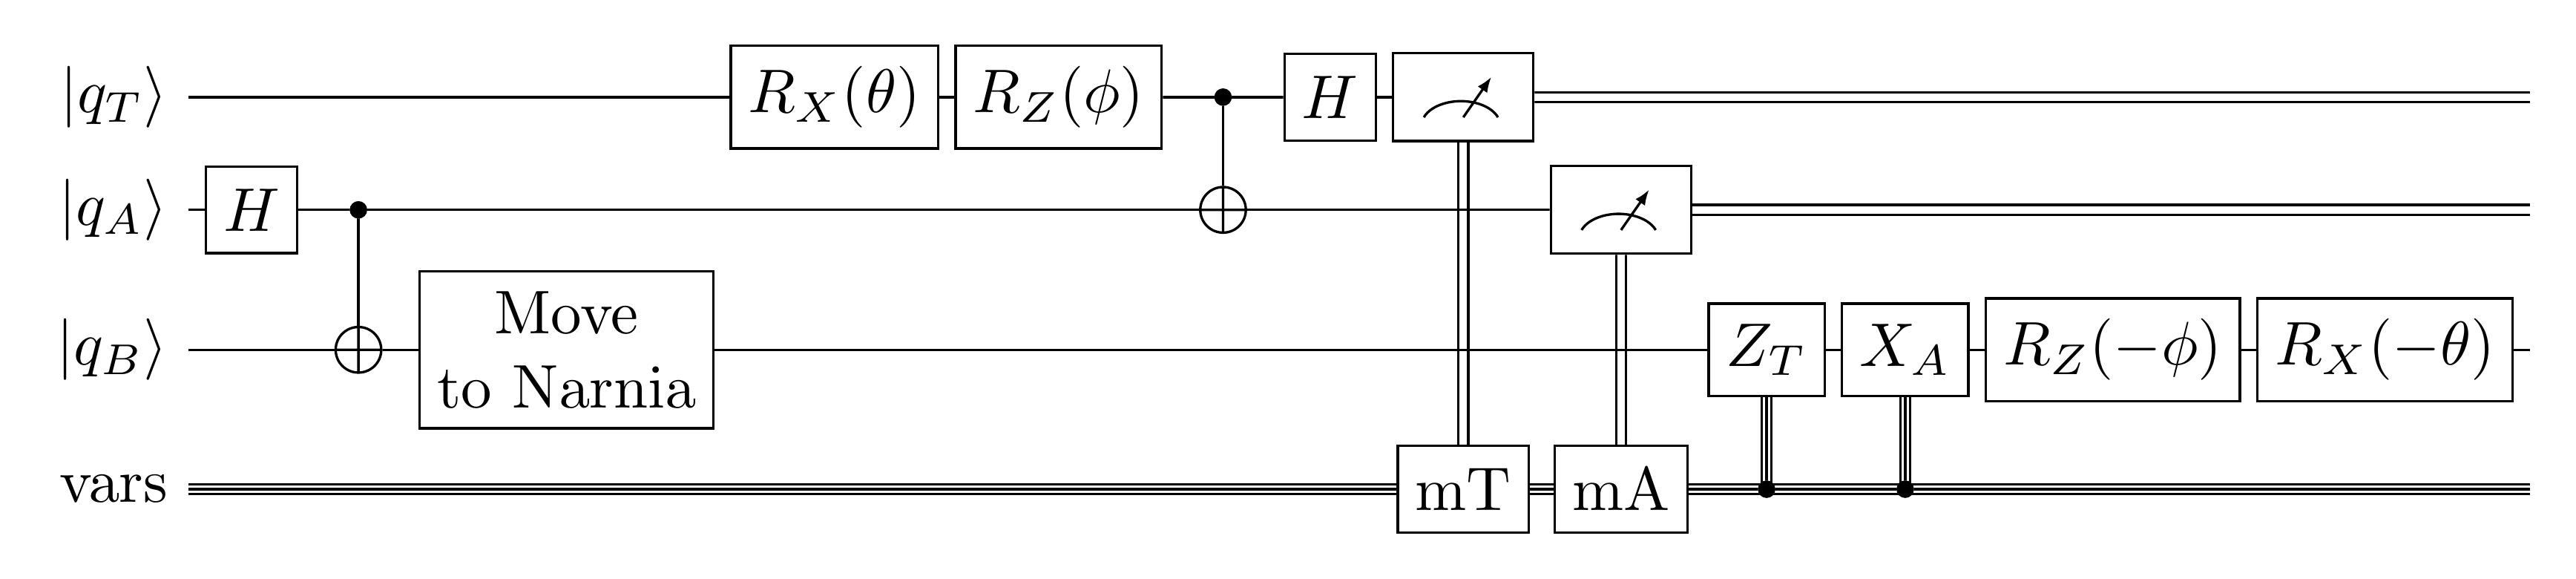

In [1]:
from rsp.utils.visualize import plot_quantum_circuit
from IPython.display import Image
# This would run with latex installed
# img = plot_quantum_circuit(qc, {'T':'q_T', 'A':'q_A', 'B':'q_B'}, show_vars=True)

# Otherwise, we can use an already generated image
img = '/content/KAT-RSP-Workshop2023/code/circuit.png'
Image(filename=img, retina=True)

Run the circuit once and check the teleportation fidelity

In [ ]:
sim = Simulator(exp, atomsys)

sim.run_circuit(qc, save_states=True)

fid = np.abs(sim.psi.overlap(atomsys.ket(('B', '0'))))
print(f"Teleportation fidelity: {fid}")

Or run it many times and obtain statistics

Gate caching is very important here to make the execution fast

In [ ]:
from rsp.core.simulation import Simulator
from timeit import default_timer as timer

sim = Simulator(exp, atomsys)

n_experiments = 50 

data = []

final_states = []

print("Running simulation...")
start = timer()
cvars, states = sim.run_circuit_statistical(qc, 
                                            num_runs=n_experiments,
                                            save_states=True, 
                                            track_end_state=True,
                                            runtime_caching=True)
print(f"Simulation took {timer()-start:.3} s")


for mA, mT, state in zip(cvars['mA'], cvars['mT'], states):
    overlap = (atomsys.ket(('B', '0')).dag() * state ).norm()
    data.append([mA, mT, overlap])
    

The average fidelity is computed through a geometric mean

In [ ]:

# calculating the geometric average over the 50 samples
gavg = 1
for _, _, overlap in data:
    gavg *= overlap
gavg = np.power(gavg, 1/len(data))
print(f"Fidelity average: {gavg:.3}")